In [1]:
# %%
import pandas as pd
import wbgapi as wb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import os
from pathlib import Path
import statsmodels.formula.api as smf
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

# Folder structure

In [2]:
# folder constants
BASE_FOLDER = Path(".").resolve().parent
DATA_FOLDER = BASE_FOLDER / "data"
RESULTS_FOLDER = BASE_FOLDER / "results"

# DATA
RAW_FOLDER = DATA_FOLDER / "raw"
WORKING_FOLDER = DATA_FOLDER / "working"
OUTPUT_FOLDER = DATA_FOLDER / "output"

# RESULTS
RAW_RESULTS_FOLDER = RESULTS_FOLDER / "raw"
FINAL_RESULTS_FOLDER = RESULTS_FOLDER / "final"
TABLES_FOLDER = FINAL_RESULTS_FOLDER / "tables"
GRAPHS_FOLDER = FINAL_RESULTS_FOLDER / "graphs"

# create folders if they don't exist
for folder in [
    DATA_FOLDER,
    RAW_FOLDER,
    WORKING_FOLDER,
    OUTPUT_FOLDER,
    RESULTS_FOLDER,
    RAW_RESULTS_FOLDER,
    FINAL_RESULTS_FOLDER,
    TABLES_FOLDER,
    GRAPHS_FOLDER,
]:
    folder.mkdir(parents=True, exist_ok=True)


# Data Collection

## Which data should we use?
Below, we use the World Bank's python SDK to find those features we want to include.

In [3]:
wb.series.info(q="gdp per capita")  # search for GDP per capita
# The series code for GDP per capita is 'NY.GDP.PCAP.PP.KD'


id,value
NY.GDP.PCAP.CD,GDP per capita (current US$)
NY.GDP.PCAP.CN,GDP per capita (current LCU)
NY.GDP.PCAP.KD,GDP per capita (constant 2015 US$)
NY.GDP.PCAP.KD.ZG,GDP per capita growth (annual %)
NY.GDP.PCAP.KN,GDP per capita (constant LCU)
NY.GDP.PCAP.PP.CD,"GDP per capita, PPP (current international $)"
NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2021 international $)"
,7 elements


In [4]:
wb.series.info(q="co2")
# The series code for total CO2 emissions is 'EN.GHG.CO2.MT.CE.AR5'


id,value
EN.GHG.CO2.AG.MT.CE.AR5,Carbon dioxide (CO2) emissions from Agriculture (Mt CO2e)
EN.GHG.CO2.BU.MT.CE.AR5,Carbon dioxide (CO2) emissions from Building (Energy) (Mt CO2e)
EN.GHG.CO2.FE.MT.CE.AR5,Carbon dioxide (CO2) emissions from Fugitive Emissions (Energy) (Mt CO2e)
EN.GHG.CO2.IC.MT.CE.AR5,Carbon dioxide (CO2) emissions from Industrial Combustion (Energy) (Mt CO2e)
EN.GHG.CO2.IP.MT.CE.AR5,Carbon dioxide (CO2) emissions from Industrial Processes (Mt CO2e)
EN.GHG.CO2.LU.DF.MT.CE.AR5,Carbon dioxide (CO2) net fluxes from LULUCF - Deforestation (Mt CO2e)
EN.GHG.CO2.LU.FL.MT.CE.AR5,Carbon dioxide (CO2) net fluxes from LULUCF - Forest Land (Mt CO2e)
EN.GHG.CO2.LU.MT.CE.AR5,Carbon dioxide (CO2) net fluxes from LULUCF - Total excluding non-tropical fires (Mt CO2e)
EN.GHG.CO2.LU.OL.MT.CE.AR5,Carbon dioxide (CO2) net fluxes from LULUCF - Other Land (Mt CO2e)
EN.GHG.CO2.LU.OS.MT.CE.AR5,Carbon dioxide (CO2) net fluxes from LULUCF - Organic Soil (Mt CO2e)


In [5]:
wb.series.info(q="population, total")
# The series code for population is 'SP.POP.TOTL'


id,value
SP.POP.TOTL,"Population, total"
,1 elements


In [6]:
wb.series.info(q="manufacturing, value added")
# The series code for Manufacturing, value added (% of GDP) is 'NV.IND.MANF.ZS'


id,value
NV.IND.MANF.CD,"Manufacturing, value added (current US$)"
NV.IND.MANF.CN,"Manufacturing, value added (current LCU)"
NV.IND.MANF.KD,"Manufacturing, value added (constant 2015 US$)"
NV.IND.MANF.KD.ZG,"Manufacturing, value added (annual % growth)"
NV.IND.MANF.KN,"Manufacturing, value added (constant LCU)"
NV.IND.MANF.ZS,"Manufacturing, value added (% of GDP)"
,6 elements


Some information retrieved from the World Bank over these series:

In [7]:
features = [
    "NY.GDP.PCAP.PP.KD",
    "SP.POP.TOTL",
    "EN.GHG.CO2.MT.CE.AR5",
    "NV.IND.MANF.ZS",
]
pd.DataFrame(
    [
        {
            "id": response["id"],
            **response["metadata"],  # Unpack metadata key-value pairs
        }
        for feature in features
        if (response := wb.series.metadata.get(feature).__dict__)
        is not None  # Ensure metadata exists
    ]
)

,id,Aggregationmethod,BasePeriod,IndicatorName,License_Type,License_URL,Longdefinition,Periodicity,Source,Statisticalconceptandmethodology,Topic,Developmentrelevance,Generalcomments,Limitationsandexceptions,Dataset,Previous_Indicator_Code,Previous_Indicator_Name,Unitofmeasure
0,NY.GDP.PCAP.PP.KD,Weighted average,2021,"GDP per capita, PPP (constant 2021 internation...",CC BY-4.0,https://datacatalog.worldbank.org/public-licen...,GDP per capita based on purchasing power parit...,Annual,"International Comparison Program, World Bank |...","For the concept and methodology of PPP, please...",Economic Policy & Debt: Purchasing power parity,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SP.POP.TOTL,Sum,NaN,"Population, total",CC BY-4.0,https://datacatalog.worldbank.org/public-licen...,Total population is based on the de facto defi...,Annual,(1) United Nations Population Division. World ...,Population estimates are usually based on nati...,Health: Population: Structure,"Increases in human population, whether as a re...",Relevance to gender indicator: disaggregating ...,Current population estimates for developing co...,NaN,NaN,NaN,NaN
2,EN.GHG.CO2.MT.CE.AR5,Sum,NaN,Carbon dioxide (CO2) emissions (total) excludi...,CC BY-4.0,https://datacatalog.worldbank.org/public-licen...,A measure of annual emissions of carbon dioxid...,Annual,EDGAR (Emissions Database for Global Atmospher...,NaN,NaN,Anthropogenic (human-caused) emissions of glob...,NaN,Global GHG emissions are currently not directl...,WDI,EN.ATM.CO2E.KT,Total CO2 emissions (thousand metric tons of C...,Mt CO2eq
3,NV.IND.MANF.ZS,Weighted average,NaN,"Manufacturing, value added (% of GDP)",CC BY-4.0,https://datacatalog.worldbank.org/public-licen...,Manufacturing refers to industries belonging t...,Annual,"World Bank national accounts data, and OECD Na...",Gross domestic product (GDP) represents the su...,Economic Policy & Debt: National accounts: Sha...,NaN,Note: Data for OECD countries are based on ISI...,"Ideally, industrial output should be measured ...",NaN,NaN,NaN,NaN


In [8]:
# saving to excel
pd.DataFrame(
    [
        {
            "id": response["id"],
            **response["metadata"],  # Unpack metadata key-value pairs
        }
        for feature in features
        if (response := wb.series.metadata.get(feature).__dict__)
        is not None  # Ensure metadata exists
    ]
).set_index("id").T.to_excel(RAW_RESULTS_FOLDER / "database_metadata.xlsx")

## Important takeaways
### Core variables
- Co2 is in Millions of Tons based on API response
  - We take the per capita in combination with population.
- GDP Per Capita is expressed in PPP (taking 2021 international $ as constant)

### Confounder, to be added later
- Level of industrialization is measured with how much added value is generated within the Manufacturing sector, expressed in % of GDP

## Downloading and saving the data

In [9]:
data = wb.data.DataFrame(features, time=range(1992, 2024), labels=True)

data.to_parquet(RAW_FOLDER / "data.parquet", compression="snappy")


# Data Wrangling and Description

## Initial preprocessing
Here, we transform our raw dataset to proper long format with separate columns for each feature.

In [10]:
df = (
    pd.read_parquet(RAW_FOLDER / "data.parquet")
    .reset_index()
    .melt(
        id_vars=[
            "Country",
            "series",
            "Series",  # This is only added for the value column capturing not to capture this aswell
            "economy",  # This too.
        ],
        var_name="year",
        value_name="value",
    )  # This has the three series' values in the same column
    .pivot(index=["Country", "year"], columns="series", values="value")
    .reset_index()
)
# cleaning the year variable
df["year"] = df["year"].str.extract(r"(\d+)").astype(int)

# renaming columns
column_mapping = {
    "Country": "country",
    "NY.GDP.PCAP.PP.KD": "gdp_percap",
    "SP.POP.TOTL": "pop",
    "EN.GHG.CO2.MT.CE.AR5": "co2",
    "NV.IND.MANF.ZS": "man_to_gdp",
}

# renaming the variables
df.rename(columns=column_mapping, inplace=True)
# add per capita co2 emissions, log of gdp per capita, and log of co2 emissions
df["co2_percap"] = (
    df["co2"] / df["pop"]
) * 1000000  # reconverting Million tons to tons per capita.
df["log_gdp_percap"] = np.log1p(df["gdp_percap"])  # log1p is log(1+x)
df["log_co2_percap"] = np.log1p(df["co2_percap"])


## Descriptive statistics of a cross-section
We gauge the nature of the distribution for each variable over a single cross-section.
- The window is arbitrary, we assume that the findings hold for all other periods aswell.
- We filter for 2005 and 2023, as we will include OLS models over those two cross-sections.

#### Figure 1
Distribution with Kernel Density plots for
- CO2 per capita (tons)
- Log CO2 per capita (log-tons)
- GDP per capita (PPP for international dollar 2021)
- Log GDP per capita
- Ratio of manufacturing sector's added value to GDP

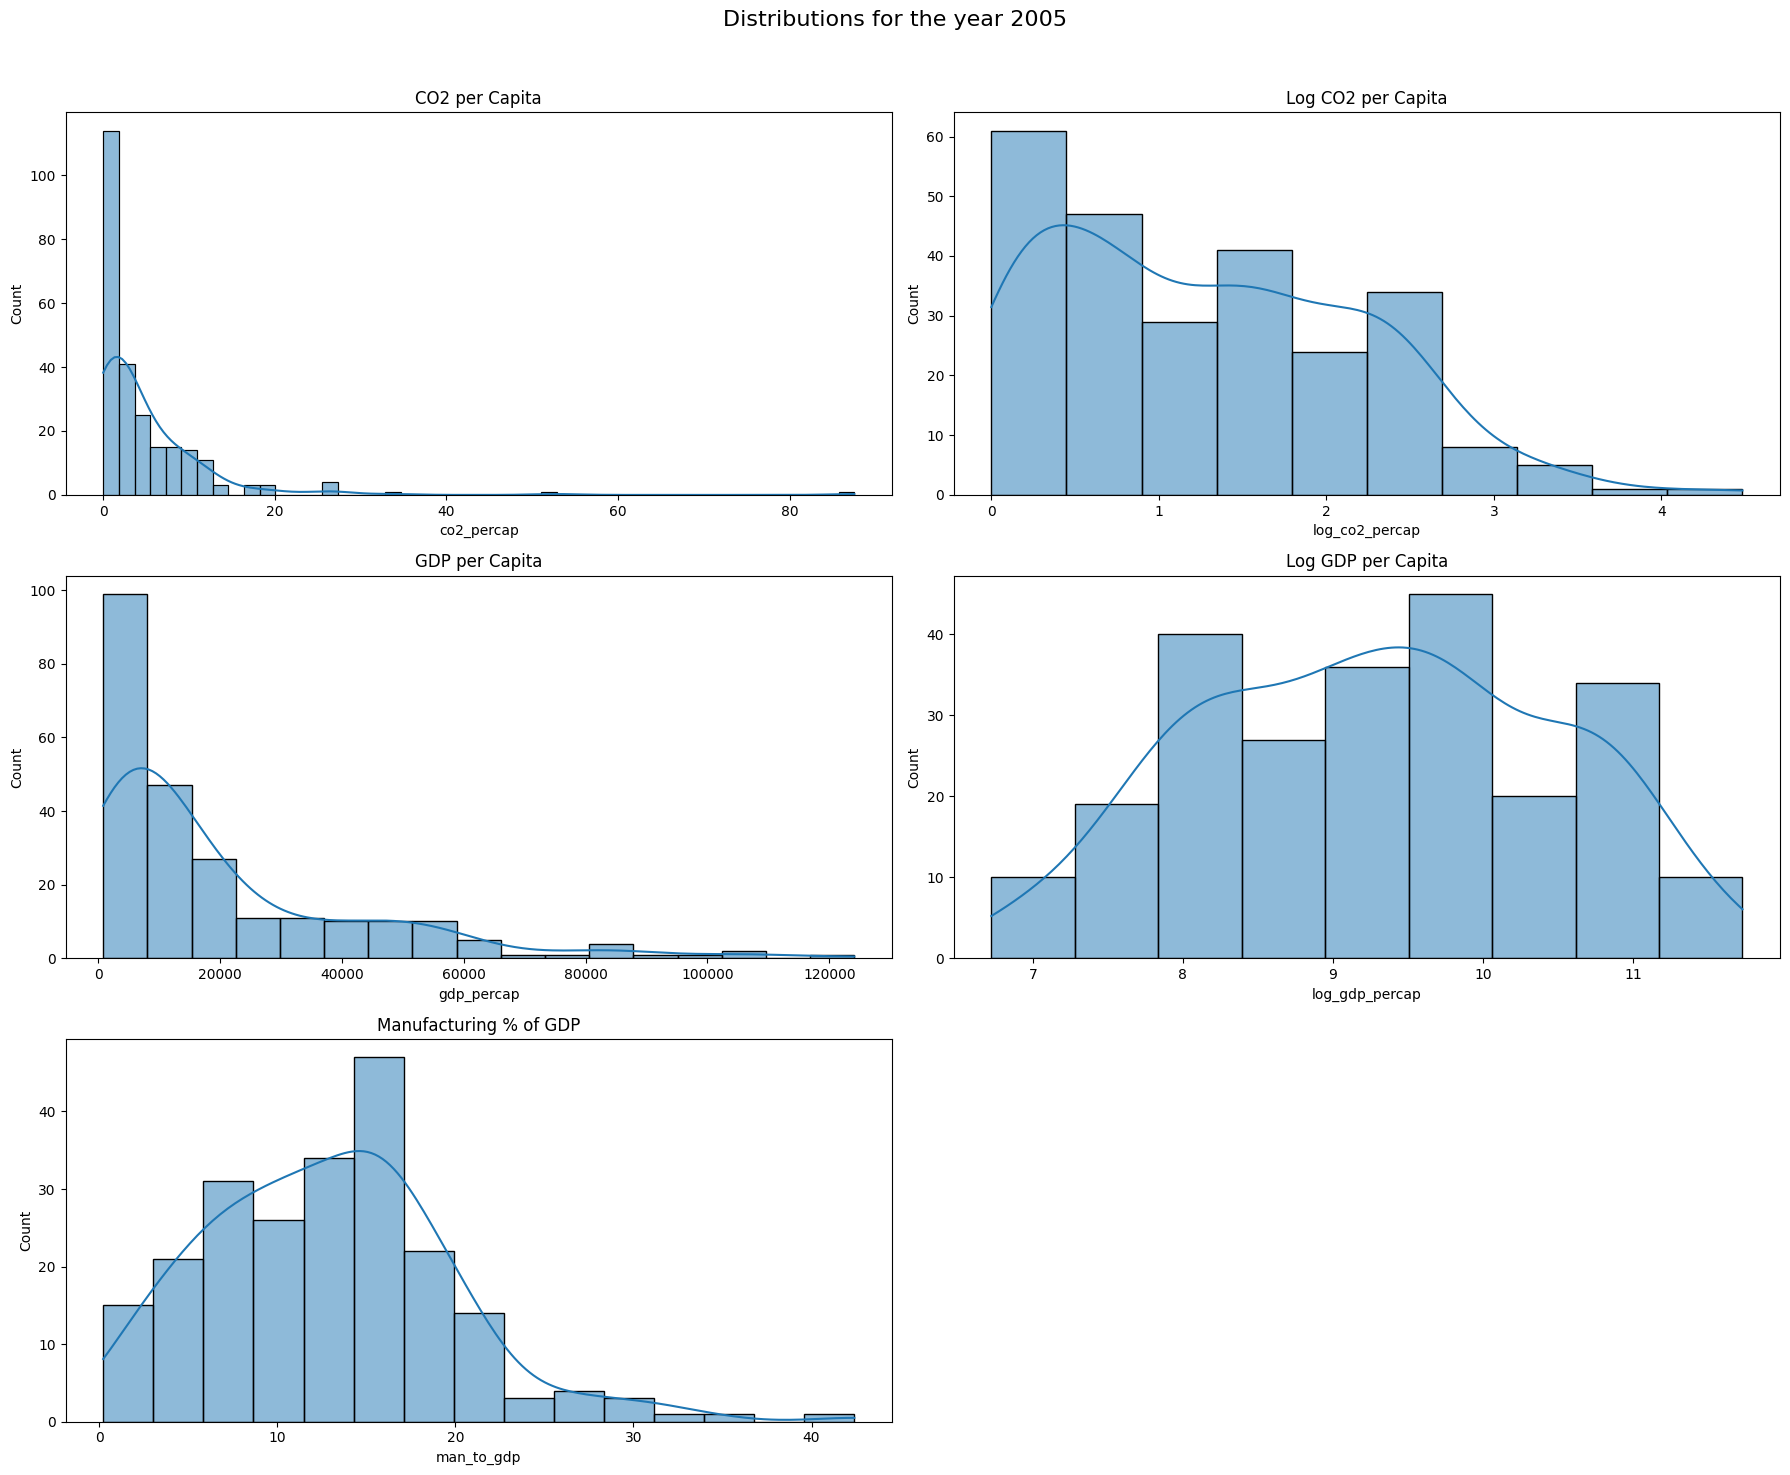

In [11]:
df_2005 = df[df["year"] == 2005]

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle("Distributions for the year 2005", fontsize=16)

# Plot histograms
sns.histplot(df_2005["co2_percap"], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("CO2 per Capita")

sns.histplot(df_2005["log_co2_percap"], kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Log CO2 per Capita")

sns.histplot(df_2005["gdp_percap"], kde=True, ax=axes[1, 0])
axes[1, 0].set_title("GDP per Capita")

sns.histplot(df_2005["log_gdp_percap"], kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Log GDP per Capita")

sns.histplot(df_2005["man_to_gdp"], kde=True, ax=axes[2, 0])
axes[2, 0].set_title("Manufacturing % of GDP")

# Hide the empty subplot
axes[2, 1].axis("off")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# save the plot
fig.savefig(GRAPHS_FOLDER / "distributions_2005.png")

In [12]:
df_2005["pop"] = df_2005["pop"] / 1_000_000  # Transform population to millions
df_2005.describe().round(4)

C:\Users\ijara_go12\AppData\Local\Temp\ipykernel_32372\1585978113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2005["pop"] = df_2005["pop"] / 1_000_000  # Transform population to millions


series,year,co2,man_to_gdp,gdp_percap,pop,co2_percap,log_gdp_percap,log_co2_percap
count,266.0,251.0000,223.0000,241.0000,265.0000,251.0000,241.0000,251.0000
mean,2005.0,1004.9597,12.8525,20140.1460,262.7536,4.8321,9.2890,1.2770
std,0.0,3286.1253,6.8975,22878.0632,827.7919,8.1465,1.1746,0.9322
min,2005.0,0.0000,0.2326,830.5092,0.0099,0.0000,6.7232,0.0000
25%,2005.0,1.7710,7.7918,4075.1586,1.3548,0.6235,8.3129,0.4846
50%,2005.0,19.3776,12.5668,10527.4748,9.0296,2.2862,9.2618,1.1897
75%,2005.0,214.5710,16.6826,27698.2160,57.9695,6.4665,10.2292,2.0104
max,2005.0,30044.5432,42.4012,124095.6173,6575.6443,87.5523,11.7288,4.4836


In [13]:
df_2005.describe().round(4).to_excel(
    RAW_RESULTS_FOLDER / "summary_statistics_2005.xlsx"
)

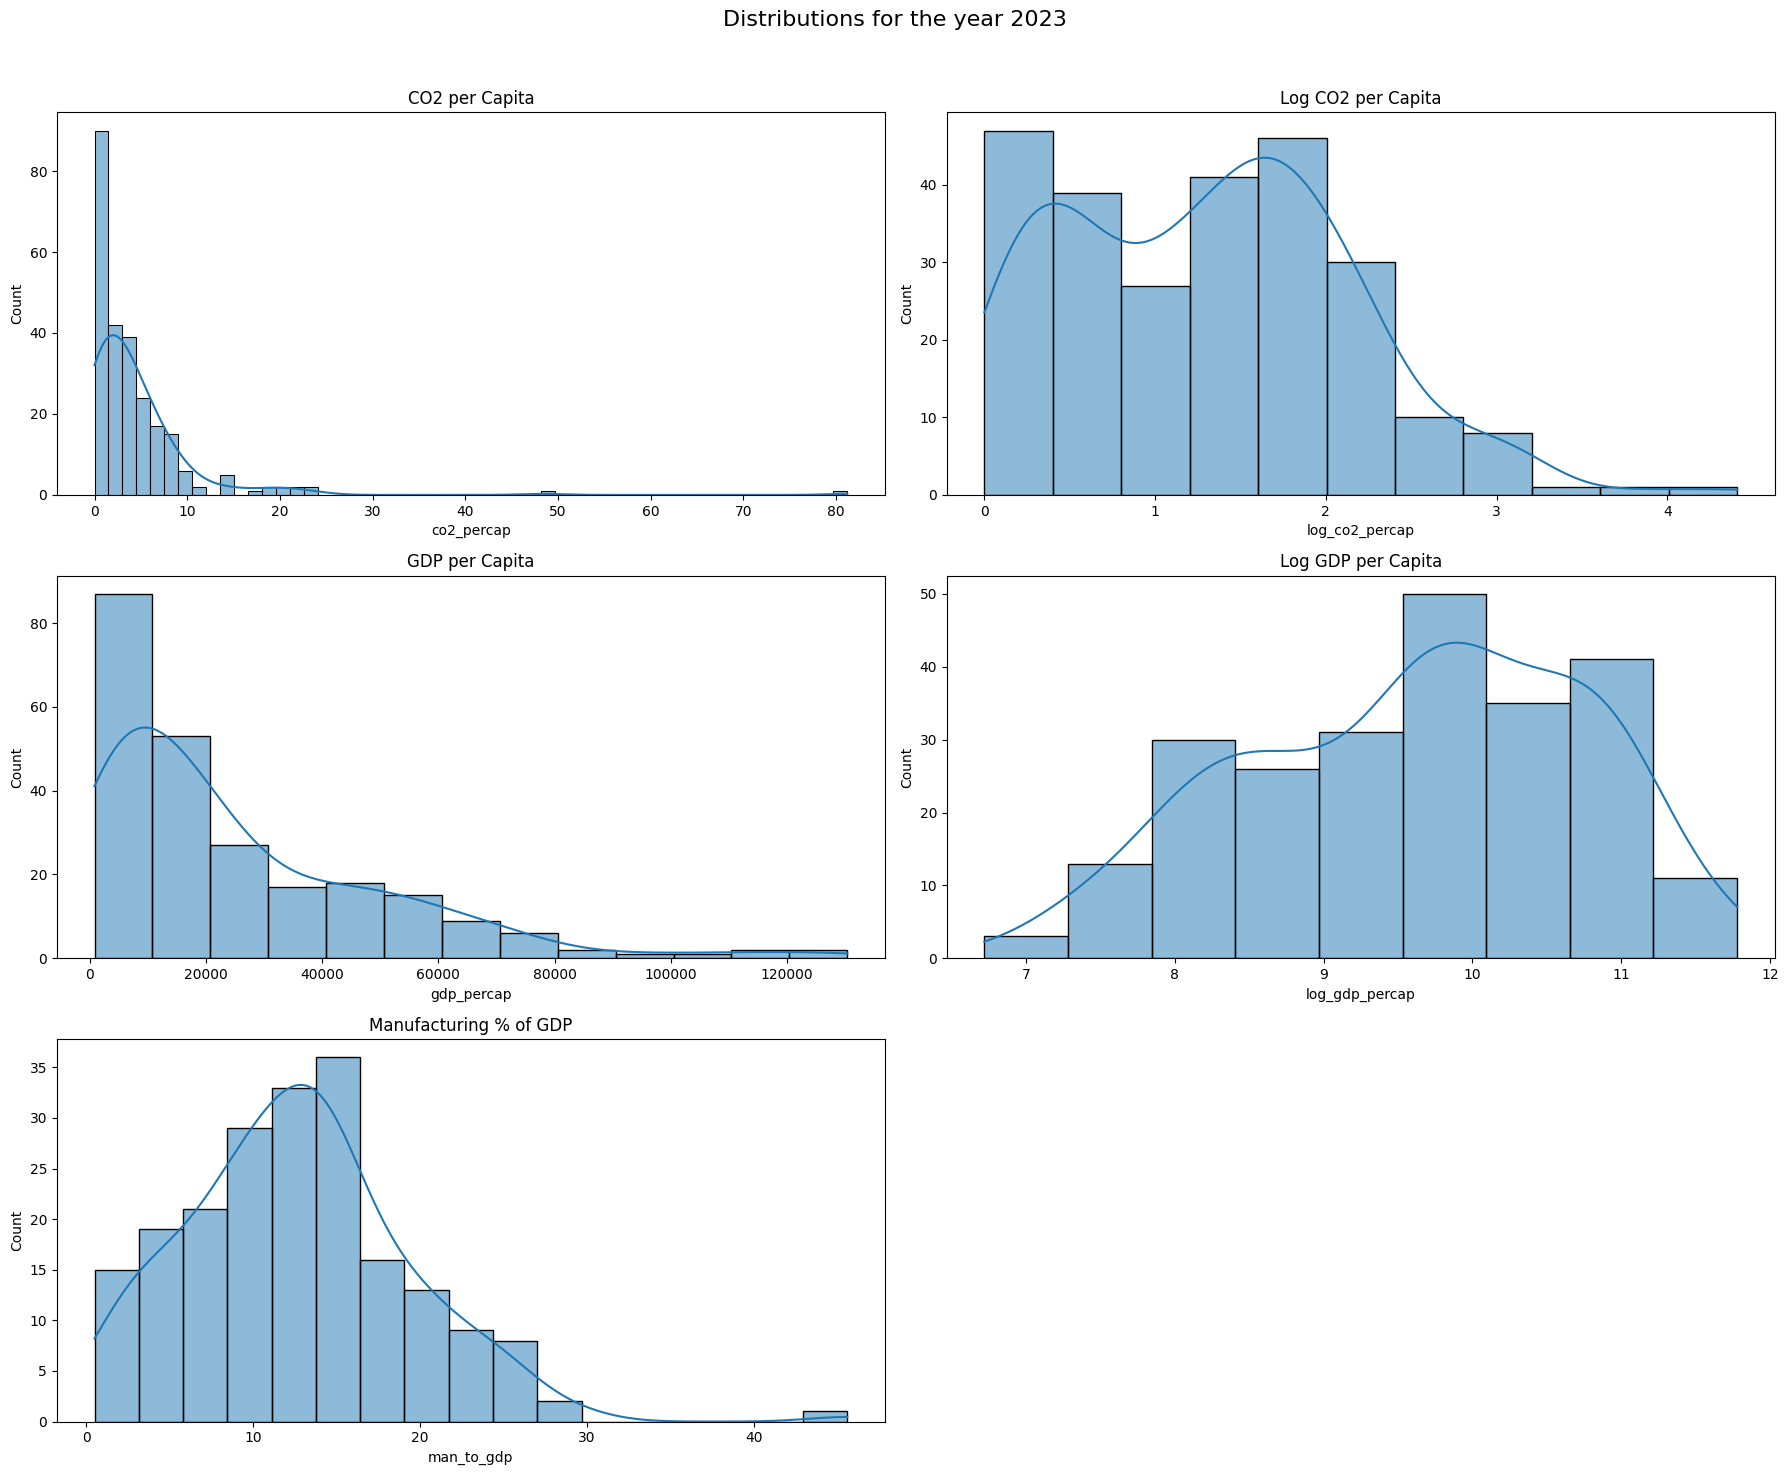

In [14]:
df_2023 = df[df["year"] == 2023]

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 2, figsize=(18, 15))
fig.suptitle("Distributions for the year 2023", fontsize=16)

# Plot histograms
sns.histplot(df_2023["co2_percap"], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("CO2 per Capita")

sns.histplot(df_2023["log_co2_percap"], kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Log CO2 per Capita")

sns.histplot(df_2023["gdp_percap"], kde=True, ax=axes[1, 0])
axes[1, 0].set_title("GDP per Capita")

sns.histplot(df_2023["log_gdp_percap"], kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Log GDP per Capita")

sns.histplot(df_2023["man_to_gdp"], kde=True, ax=axes[2, 0])
axes[2, 0].set_title("Manufacturing % of GDP")

# Hide the empty subplot
axes[2, 1].axis("off")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# save the plot
fig.savefig(GRAPHS_FOLDER / "distributions_2023.png")

In [15]:
df_2023["pop"] = df_2023["pop"] / 1_000_000  # Transform population to millions
df_2023.describe().round(4)

C:\Users\ijara_go12\AppData\Local\Temp\ipykernel_32372\2526776508.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2023["pop"] = df_2023["pop"] / 1_000_000  # Transform population to millions


series,year,co2,man_to_gdp,gdp_percap,pop,co2_percap,log_gdp_percap,log_co2_percap
count,266.0,251.0000,202.0000,240.0000,265.0000,251.0000,240.0000,251.0000
mean,2023.0,1423.7028,12.6426,25513.1676,328.7886,4.4620,9.6157,1.2997
std,0.0,4807.9239,6.7448,25132.5122,1018.5895,7.1655,1.1256,0.8439
min,2023.0,0.0000,0.4922,828.8611,0.0098,0.0000,6.7213,0.0000
25%,2023.0,3.7882,8.2257,6237.1051,1.8278,0.7232,8.7384,0.5442
50%,2023.0,24.1638,12.6125,17458.0862,10.6449,2.6608,9.7676,1.2977
75%,2023.0,278.2938,16.2231,39317.2012,66.6176,5.4769,10.5794,1.8682
max,2023.0,39023.9370,45.6045,130373.4779,8061.8760,81.2095,11.7782,4.4093


In [16]:
df_2023.describe().round(4).to_excel(
    RAW_RESULTS_FOLDER / "summary_statistics_2023.xlsx"
)

## Analysis of coverage

We face a dilemma:
- Either shorten window of observation
- Or include less countries

We ommit all countries that have any missing values for any of the features in the window of observation.


### General coverage of features

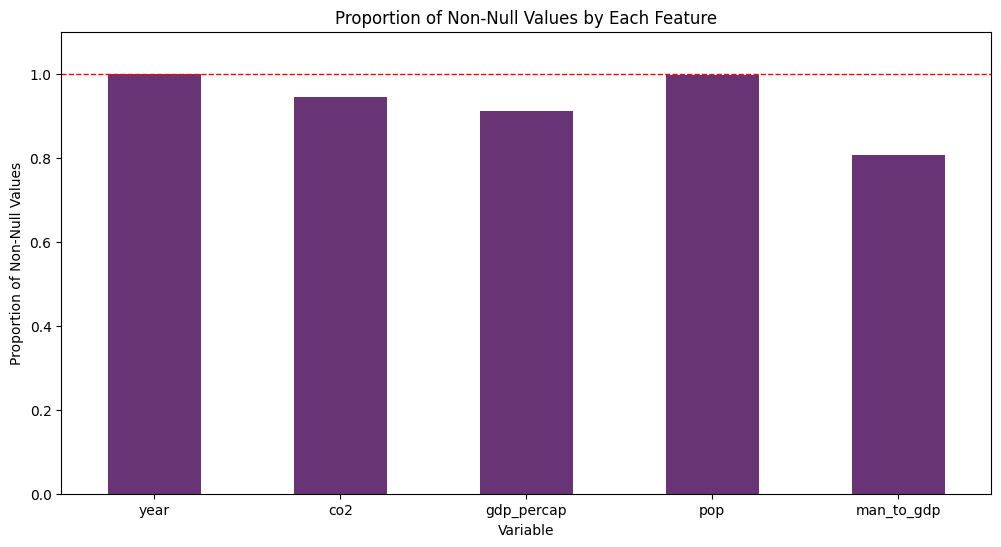

In [17]:
# Compute non-null ratios for each variable grouped by country
non_null_ratios_country = (
    df.groupby("country")[["year", "co2", "gdp_percap", "pop", "man_to_gdp"]].count()
    / df.groupby("country")[["year", "co2", "gdp_percap", "pop", "man_to_gdp"]]
    .size()
    .values[:, None]
)

# Plot bar chart for non-null ratios
plt.figure(figsize=(12, 6))
non_null_ratios_country.mean().plot(
    kind="bar", stacked=True, colormap="viridis", alpha=0.8
)
plt.axhline(
    y=1, color="r", linestyle="--", linewidth=1
)  # Add horizontal dashed line at y=1
plt.xlabel("Variable")
plt.ylabel("Proportion of Non-Null Values")
plt.title("Proportion of Non-Null Values by Each Feature")
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.savefig(GRAPHS_FOLDER / "non_null_ratios.png")
plt.show()
# save figure


We distinguish between the core features (co2, gdp_percap, pop) and the remaining (which is the confounder in this case, man_to_gdp).

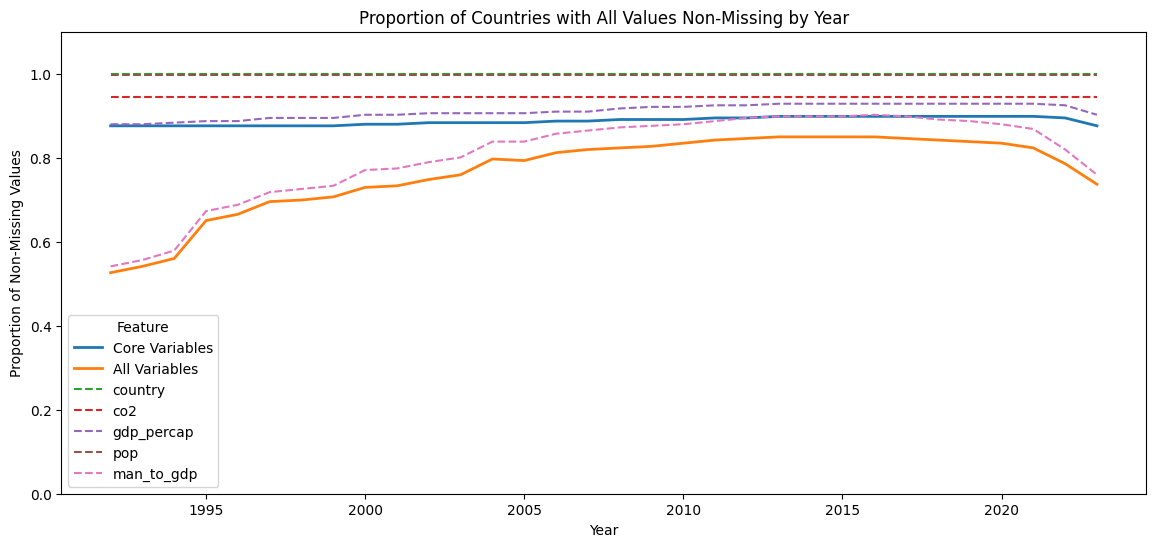

In [18]:
df["at_least_one_missing_core"] = df[["co2", "gdp_percap", "pop"]].isna().max(axis=1)
df["at_least_one_missing_all"] = (
    df[["co2", "gdp_percap", "pop", "man_to_gdp"]].isna().max(axis=1)
)

fig, ax = plt.subplots(figsize=(14, 6))

# Plot for core variables
sns.lineplot(
    data=1
    - (
        df.groupby("year")["at_least_one_missing_core"].sum()
        / df.groupby("year")["country"].count()
    ),
    ax=ax,
    linewidth=2,
    label="Core Variables",
)

# Plot for all variables including confounder
sns.lineplot(
    data=1
    - (
        df.groupby("year")["at_least_one_missing_all"].sum()
        / df.groupby("year")["country"].count()
    ),
    ax=ax,
    linewidth=2,
    label="All Variables",
)

# Plot additional variables with dashed lines
non_null_ratios_year = (
    df.groupby("year")[["country", "co2", "gdp_percap", "pop", "man_to_gdp"]].count()
    / df.groupby("year")[["country", "co2", "gdp_percap", "pop", "man_to_gdp"]]
    .size()
    .values[:, None]
)

for column in non_null_ratios_year.columns:
    sns.lineplot(
        data=non_null_ratios_year[column],
        ax=ax,
        linestyle="--",
        label=column,
    )

ax.set_title("Proportion of Countries with All Values Non-Missing by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Proportion of Non-Missing Values")
ax.legend(title="Feature")
plt.ylim(0, 1.1)
# save figure
plt.savefig(GRAPHS_FOLDER / "missing_values_by_year.png")
plt.show()

Lines represent the ratio of countries without a missing value
- Dashed lines represent the single features
- Continuous lines represent a bag of features, where if any is missing for a country, we consider that country "missing"


Conclusion: We see, that the data coverage is stable for the core variables and somewhat stable between around 2005 and 2020

We decided to first only filter our dataset based on the core set of variables:
- We ommit each country that has any missing values between 1992 and 2023
- We do this before the OLS analyses so that our findings are comparable.
- When later we include the confounder, we will filter the dataset and repeat our regression estimates for comparable results.

## Creating subsets of data with no missing values

### Inputing with average if only one year is missing

In [19]:
df = df.sort_values(by=["country", "year"])

In [20]:
# Get the columns to fill (excluding categorical ones)
cols_to_fill = [
    "co2",
    "man_to_gdp",
    "gdp_percap",
    "pop",
    "co2_percap",
    "log_gdp_percap",
    "log_co2_percap",
]

# Identify missing values and check if only one year is missing in a row
for col in cols_to_fill:
    df[f"{col}_imputed"] = False  # Initialize flag column

    mask = df[col].isna()

    # Find positions where exactly one missing value is surrounded by non-missing values
    prev_valid = df[col].shift(1)
    next_valid = df[col].shift(-1)
    only_one_missing = mask & prev_valid.notna() & next_valid.notna()

    # Fill missing values with the average of previous and next year
    df.loc[only_one_missing, col] = (prev_valid + next_valid) / 2

    # Set flag to True where imputation occurred
    df.loc[only_one_missing, f"{col}_imputed"] = True

In [21]:
df[
    [
        "co2_imputed",
        "man_to_gdp_imputed",
        "gdp_percap_imputed",
        "pop_imputed",
        "co2_percap_imputed",
        "log_gdp_percap_imputed",
        "log_co2_percap_imputed",
    ]
].sum()

series
co2_imputed                0
man_to_gdp_imputed        13
gdp_percap_imputed         5
pop_imputed                0
co2_percap_imputed         0
log_gdp_percap_imputed     5
log_co2_percap_imputed     0
dtype: int64

In [22]:
# Identify countries with any imputed values
imputed_countries = df[
    df[
        [
            "co2_imputed",
            "man_to_gdp_imputed",
            "gdp_percap_imputed",
            "pop_imputed",
            "co2_percap_imputed",
            "log_gdp_percap_imputed",
            "log_co2_percap_imputed",
        ]
    ].any(axis=1)
]["country"].value_counts()

print("Countries with any imputed values:")
print(imputed_countries)

Countries with any imputed values:
country
Bermuda                 1
Bhutan                  1
Cambodia                1
Czechia                 1
Guinea                  1
Guyana                  1
Israel                  1
Jamaica                 1
Japan                   1
Lebanon                 1
Papua New Guinea        1
San Marino              1
Syrian Arab Republic    1
Tajikistan              1
Tonga                   1
Trinidad and Tobago     1
Turkmenistan            1
Name: count, dtype: int64


### Checking conditional distributions of variables based on whether manufacturing is missing
- We will do so on 3 different cross-sections: 
  - one around the beginning of our data (1996)
  - And the other two at the stablished points

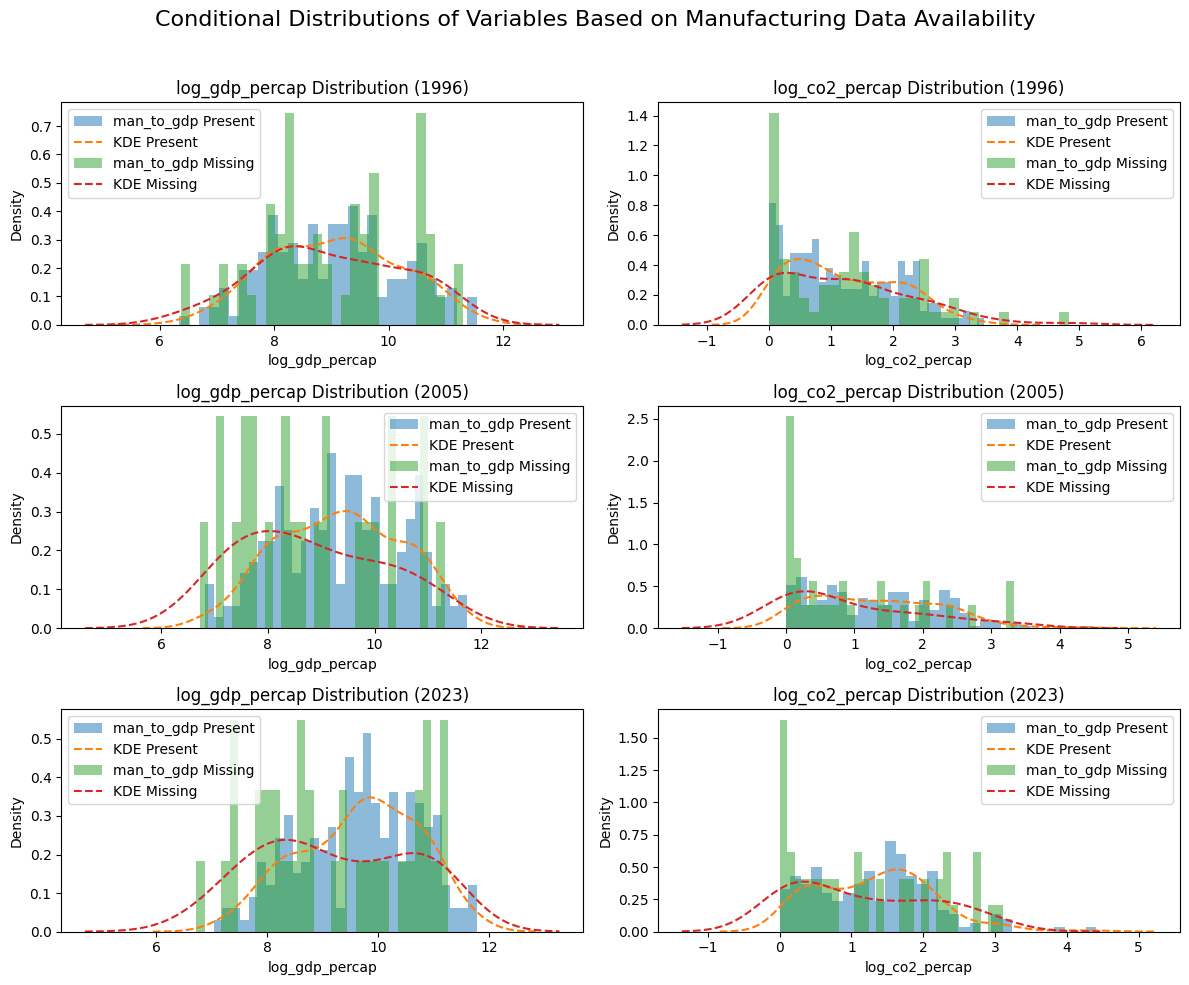

In [23]:
years_of_interest = [1996, 2005, 2023]
variables = ["log_gdp_percap", "log_co2_percap"]

# Reattempt visualization using histograms and KDE plots
fig, axes = plt.subplots(len(years_of_interest), len(variables), figsize=(12, 10))
fig.suptitle(
    "Conditional Distributions of Variables Based on Manufacturing Data Availability",
    fontsize=16,
)

for i, year in enumerate(years_of_interest):
    df_year = df[df["year"] == year].copy()

    for j, var in enumerate(variables):
        ax = axes[i, j] if len(years_of_interest) > 1 else axes[j]

        # Ensure valid numeric data for histogram plot
        present_data = df_year[df_year["man_to_gdp"].notna()][var].dropna()
        missing_data = df_year[df_year["man_to_gdp"].isna()][var].dropna()

        if not present_data.empty:
            ax.hist(
                present_data,
                bins=30,
                alpha=0.5,
                label="man_to_gdp Present",
                density=True,
            )
            sns.kdeplot(present_data, ax=ax, label="KDE Present", linestyle="--")
        if not missing_data.empty:
            ax.hist(
                missing_data,
                bins=30,
                alpha=0.5,
                label="man_to_gdp Missing",
                density=True,
            )
            sns.kdeplot(missing_data, ax=ax, label="KDE Missing", linestyle="--")

        ax.set_title(f"{var} Distribution ({year})")
        ax.set_xlabel(var)
        ax.set_ylabel("Density")
        ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
# save figure
plt.savefig(GRAPHS_FOLDER / "conditional_distributions.png")
plt.show()

Conclusion: There may be a systematic bias: Less developed countries appear to have more missing data on manufacturing ratio reported.
- The log gdp appears to be more influenced (indicating that that is more systematic)
- Contrary to expectations, this difference appears to be more pronounced in 2005 and 2023 than in 1996.
  - This could mean that richer countries adopted this measure  more successfully.
- This may bias our findings, limiting the strength of the expected relationship between a country's wealth and CO2 

### Creating the subsets, dropping all countries with missing data

#### Subset 1 - without the confounder

In [24]:
def create_subsets_with_detailed_stats(
    df, core_vars, confounder, start_year_1, end_year_1, start_year_2, end_year_2
):
    """
    Create two subsets of the dataframe with different time windows and log omitted countries with detailed statistics.

    Parameters:
    df (pd.DataFrame): The input panel dataframe.
    core_vars (list): The core variables used for filtering.
    confounder (str): The additional confounder variable.
    start_year_1 (int): The start year of the first observation window.
    end_year_1 (int): The end year of the first observation window.
    start_year_2 (int): The start year of the second observation window.
    end_year_2 (int): The end year of the second observation window.

    Returns:
    dict: A dictionary containing subsets and statistics about omitted countries.
    """

    def compute_detailed_omission_stats(missing_countries, df_filtered, variables):
        """Compute detailed statistics for omitted countries."""
        omitted_df = df_filtered[df_filtered["country"].isin(missing_countries)]
        count_missing_per_var = omitted_df.groupby("country")[variables].apply(
            lambda x: x.isnull().sum()
        )
        avg_values = omitted_df.groupby("country")[variables].mean()
        omitted_stats = count_missing_per_var.join(
            avg_values, lsuffix="_missing", rsuffix="_avg"
        )
        return omitted_stats

    # Filter the time window for subset 1
    df_filtered_1 = df[(df["year"] >= start_year_1) & (df["year"] <= end_year_1)]
    # Identify countries with any missing values in core variables
    missing_core_1 = df_filtered_1.groupby("country")[core_vars].apply(
        lambda x: x.isnull().any().any()
    )
    omitted_countries_1 = missing_core_1[missing_core_1].index.tolist()
    omitted_stats_1 = compute_detailed_omission_stats(
        omitted_countries_1, df_filtered_1, core_vars
    )
    # Create first subset
    subset_1 = df_filtered_1[~df_filtered_1["country"].isin(omitted_countries_1)]

    # Filter the time window for subset 2
    df_filtered_2 = df[(df["year"] >= start_year_2) & (df["year"] <= end_year_2)]
    # Identify countries with any missing values in core variables + confounder
    missing_with_confounder_2 = df_filtered_2.groupby("country")[
        core_vars + [confounder]
    ].apply(lambda x: x.isnull().any().any())
    omitted_countries_2 = missing_with_confounder_2[
        missing_with_confounder_2
    ].index.tolist()
    omitted_stats_2 = compute_detailed_omission_stats(
        omitted_countries_2, df_filtered_2, core_vars + [confounder]
    )
    # Create second subset
    subset_2 = df_filtered_2[~df_filtered_2["country"].isin(omitted_countries_2)]

    # Organize results in a dictionary
    result = {
        "subset_1": subset_1,
        "subset_2": subset_2,
        "omitted_1": {"countries": omitted_countries_1, "stats": omitted_stats_1},
        "omitted_2": {"countries": omitted_countries_2, "stats": omitted_stats_2},
    }

    return result


core_variables = ["log_gdp_percap", "co2_percap"]
confounder_variable = "man_to_gdp"
start_year_1 = 1992
end_year_1 = 2023
start_year_2 = (
    2002  # We have seen before that the coverage steadily improves until the mid 2000s
)
end_year_2 = 2020  # We see that the coverage drops slightly after 2020

# Generate results
result_dict = create_subsets_with_detailed_stats(
    df,
    core_variables,
    confounder_variable,
    start_year_1,
    end_year_1,
    start_year_2,
    end_year_2,
)


In [25]:
# Our subset with omission based only the log gdp and co2 emission variables
df_core = result_dict["subset_1"]

In [26]:
# Our subset, which includes the confounder variable in the omission criteria as well
df_confounder = result_dict["subset_2"]

Which countries were ommitted?

In [27]:
result_dict["omitted_1"]["stats"].to_excel(TABLES_FOLDER / "omitted_based_on_core.xlsx")

In [28]:
result_dict["omitted_2"]["stats"].to_excel(TABLES_FOLDER / "omitted_based_on_all.xlsx")

In [29]:
# number of countries ommitted
print(
    f"Number of countries omitted based on core variables: {len(result_dict['omitted_1']['countries'])}"
)
print(
    f"Number of countries omitted based on all variables: {len(result_dict['omitted_2']['countries'])}"
)

Number of countries omitted based on core variables: 34
Number of countries omitted based on all variables: 76


# Analysis

First, we will carry out all 6 steps of our analysis based on two variables:
- Log of GDP per capita (measured in PPP, with "international dollars" held constant at 2021)
- Log of co2 emissions per capita (measured in tons, after refactoring the variable from million tons to tons)

Then, we will repeat some steps, with our confounder variable included
- Added value in Manufacturing sector (measured in % of GDP, which measures the total added value domestically)

We will use a more strict filtering of countries when we introduce the confounding variable to the analysis based on missing data.

The subsets are the following, with all countries ommitted, that have any missing value:
- First subset: 
  - 1992-2023 
  - Filtering based on log of GDP per capita and log of CO2 emissions per capita
  - 232 countries
- Second subset:
  - 2006-2020
  - Filtering based on log of GDP per capita, log of CO2 emissions per capita and manufacturing ratio.
  - 209 countries

In order to keep our results consistent between the cross-sectional and panel results, we only use the subsetted databases for the entire analysis.

## Cross-section OLS for 2005

In [30]:
model_ols_2005 = smf.ols(
    formula="log_co2_percap ~ log_gdp_percap", data=df_core[df_core["year"] == 2005]
).fit(cov_type="HC1")
print(model_ols_2005.summary())

                            OLS Regression Results                            
Dep. Variable:         log_co2_percap   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     703.1
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           6.88e-72
Time:                        02:27:35   Log-Likelihood:                -154.78
No. Observations:                 232   AIC:                             313.6
Df Residuals:                     230   BIC:                             320.5
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.0736      0.229    -22.

First, we ran a simple OLS regression:
- dependent variable is log of CO2 emissions per capita
- the explanatory variable is the log of the GDP per capita

We can see, that these two features are positively correlated:
- The coefficient of the estimated Beta is 0.6883, and it is strongly significant.
  - This can be interpreted as a 1% higher GDP per capita is associated with a 0.69% higher level of CO2 emissions per capita, on average.
  - Based on this model, and (wrongly) assuming that the specification captures the real-world relationship, we cannot reject that there is no relationship between the two variables
- The R^2 is 0.742. This indicates, that a 74% of the variance in the CO2 emissions is explained by the variance in the GDP per capita.


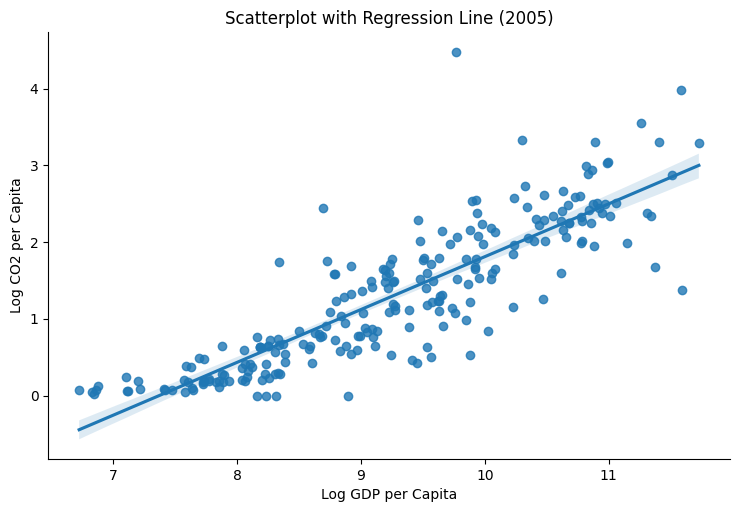

In [31]:
# Scatterplot with regression line for the year 2005
sns.lmplot(
    x="log_gdp_percap",
    y="log_co2_percap",
    data=df_core[df_core["year"] == 2005],
    aspect=1.5,
)
plt.title("Scatterplot with Regression Line (2005)")
plt.xlabel("Log GDP per Capita")
plt.ylabel("Log CO2 per Capita")
plt.show()

Putting our results on a scatterplot, we can see, that the distribution of the error terms is heterogenous: 
- a higher level of the log of GDP per capita is associated with higher variance
- A slight convex relationship can be observed at lower GDP per capita levels. This may be the result of the log transformations.

## Cross-section OLS for 2023

In [32]:
model_ols_2023 = smf.ols(
    formula="log_co2_percap ~ log_gdp_percap", data=df_core[df_core["year"] == 2023]
).fit(cov_type="HC1")
print(model_ols_2023.summary())

                            OLS Regression Results                            
Dep. Variable:         log_co2_percap   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     652.1
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           4.46e-69
Time:                        02:27:35   Log-Likelihood:                -147.63
No. Observations:                 232   AIC:                             299.3
Df Residuals:                     230   BIC:                             306.2
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -4.5417      0.218    -20.

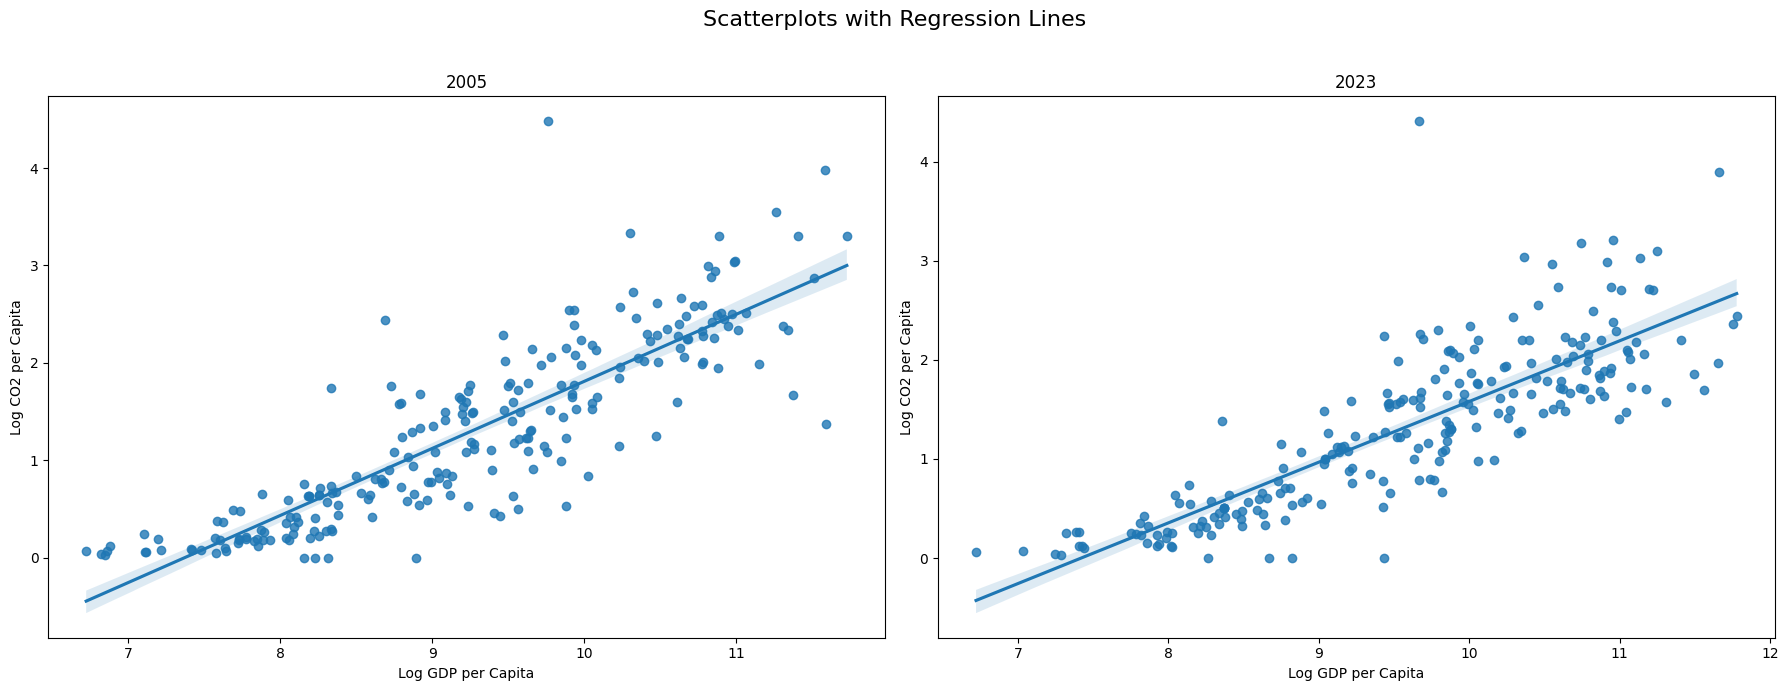

In [33]:
# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle("Scatterplots with Regression Lines", fontsize=16)

# Scatterplot with regression line for the year 2005
sns.regplot(
    x="log_gdp_percap",
    y="log_co2_percap",
    data=df_core[df_core["year"] == 2005],
    ax=axes[0],
)
axes[0].set_title("2005")
axes[0].set_xlabel("Log GDP per Capita")
axes[0].set_ylabel("Log CO2 per Capita")

# Scatterplot with regression line for the year 2023
sns.regplot(
    x="log_gdp_percap",
    y="log_co2_percap",
    data=df_core[df_core["year"] == 2023],
    ax=axes[1],
)
axes[1].set_title("2023")
axes[1].set_xlabel("Log GDP per Capita")
axes[1].set_ylabel("Log CO2 per Capita")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
# save figure
plt.savefig(GRAPHS_FOLDER / "scatterplots_with_regression_lines.png")
plt.show()

Comparing the two regressions:

| Year | Coefficient | Interpretation | R^2 | Interpretation |
|------|-----------------|-----------------------------|------|-------------------------------|
| **2005** | 0.6883 | A 1% increase in GDP per capita is associated with a **0.6883% increase** in CO₂ emissions per capita. | 0.742 | 74.2% of the variance in CO₂ per capita is explained by GDP per capita. |
| **2023** | 0.6121 | A 1% increase in GDP per capita is associated with a **0.6121% increase** in CO₂ emissions per capita. | 0.692 | 69.2% of the variance in CO₂ per capita is explained by GDP per capita. |

**Key Takeaways:**
- The elasticity **has decreased** from **0.6883 to 0.6121**, indicating a weaker association between GDP growth and CO₂ emissions.
- The R^2 value has also **declined**, suggesting that GDP per capita alone explains **less** of the variation in CO₂ emissions than before.


Comparing the two scatterplots:
- The error term still appears to be heteroscedastic
- Some convex non-linearity still holds

## First Difference model

### Creating models

In [34]:
# Model with time trend dummies & country fixed effects
df_core = df_core.copy()
df_core["d_log_co2_percap"] = df_core["log_co2_percap"].diff()
df_core["d_log_gdp_percap"] = df_core["log_gdp_percap"].diff()
df_core["time_trend"] = df_core["year"] - df_core["year"].min()

# Drop NaNs from first differencing
df_core_diff = df_core.dropna(subset=["d_log_co2_percap", "d_log_gdp_percap"]).copy()

# Model with time trend dummies (No FE)
model_fd_dummies = smf.ols(
    formula="d_log_co2_percap ~ d_log_gdp_percap + C(time_trend)",
    data=df_core_diff,
).fit(cov_type="HC1")

# Model with time trend dummies & country fixed effects (With FE)
model_fd_dummies_fe = smf.ols(
    formula="d_log_co2_percap ~ d_log_gdp_percap + C(time_trend) + C(country)",
    data=df_core_diff,
).fit(cov_type="HC1")

# Model with linear time trend (No FE)
model_fd_linear = smf.ols(
    formula="d_log_co2_percap ~ d_log_gdp_percap + time_trend",
    data=df_core_diff,
).fit(cov_type="HC1")

# Model with linear time trend & country fixed effects (With FE)
model_fd_linear_fe = smf.ols(
    formula="d_log_co2_percap ~ d_log_gdp_percap + time_trend + C(country)",
    data=df_core_diff,
).fit(cov_type="HC1")

# --------- Create Lags Separately for Each Model ---------

# 2-year lags only
df_2yr_lag = df_core_diff.copy()
df_2yr_lag["d_log_gdp_percap_lag_1"] = df_2yr_lag.groupby("country")[
    "d_log_gdp_percap"
].shift(1)
df_2yr_lag["d_log_gdp_percap_lag_2"] = df_2yr_lag.groupby("country")[
    "d_log_gdp_percap"
].shift(2)
df_2yr_lag = df_2yr_lag.dropna()

# 6-year lags only
df_6yr_lag = df_2yr_lag.copy()
for lag in range(3, 7):
    df_6yr_lag[f"d_log_gdp_percap_lag_{lag}"] = df_6yr_lag.groupby("country")[
        "d_log_gdp_percap"
    ].shift(lag)
df_6yr_lag = df_6yr_lag.dropna()

# Model with up to 2-year lags (No FE)
model_fd_2yr_lag = smf.ols(
    formula="d_log_co2_percap ~ d_log_gdp_percap + d_log_gdp_percap_lag_1 + d_log_gdp_percap_lag_2",
    data=df_2yr_lag,
).fit(cov_type="HC1")

# Model with up to 2-year lags & country fixed effects (With FE)
model_fd_2yr_lag_fe = smf.ols(
    formula="d_log_co2_percap ~ d_log_gdp_percap + d_log_gdp_percap_lag_1 + d_log_gdp_percap_lag_2 + C(country)",
    data=df_2yr_lag,
).fit(cov_type="HC1")

# Model with up to 6-year lags (No FE)
model_fd_6yr_lag = smf.ols(
    formula="d_log_co2_percap ~ d_log_gdp_percap + d_log_gdp_percap_lag_1 + d_log_gdp_percap_lag_2 + "
    "d_log_gdp_percap_lag_3 + d_log_gdp_percap_lag_4 + d_log_gdp_percap_lag_5 + d_log_gdp_percap_lag_6",
    data=df_6yr_lag,
).fit(cov_type="HC1")

# Model with up to 6-year lags & country fixed effects (With FE)
model_fd_6yr_lag_fe = smf.ols(
    formula="d_log_co2_percap ~ d_log_gdp_percap + d_log_gdp_percap_lag_1 + d_log_gdp_percap_lag_2 + "
    "d_log_gdp_percap_lag_3 + d_log_gdp_percap_lag_4 + d_log_gdp_percap_lag_5 + d_log_gdp_percap_lag_6 + C(country)",
    data=df_6yr_lag,
).fit(cov_type="HC1")

# Verify that 2-year lag dataset has more observations than 6-year lag dataset
print("Observations in 2-year lag model:", df_2yr_lag.shape[0])
print("Observations in 6-year lag model:", df_6yr_lag.shape[0])


Observations in 2-year lag model: 6156
Observations in 6-year lag model: 4806


### Without fixed effects

In [35]:
# Create Stargazer table
stargazer_fd = Stargazer(
    [model_fd_dummies, model_fd_linear, model_fd_2yr_lag, model_fd_6yr_lag]
)

# Customize Stargazer output
stargazer_fd.title("Fixed Differences Models")
stargazer_fd.custom_columns(
    ["Dummies", "Linear Trend", "Up to 2-Year Lags", "Up to 6-Year Lags"], [1, 1, 1, 1]
)
stargazer_fd.add_line("Time Trend Dummies", ["Yes", "No", "No", "No"])
stargazer_fd.add_line("Linear Time Trend", ["No", "Yes", "No", "No"])
stargazer_fd.add_line("GDP Lags up to 2 Years", ["No", "No", "Yes", "No"])
stargazer_fd.add_line("GDP Lags up to 6 Years", ["No", "No", "No", "Yes"])

stargazer_fd.covariate_order(
    [
        "Intercept",
        "d_log_gdp_percap",
        "time_trend",
        "d_log_gdp_percap_lag_1",
        "d_log_gdp_percap_lag_2",
        "d_log_gdp_percap_lag_3",
        "d_log_gdp_percap_lag_4",
        "d_log_gdp_percap_lag_5",
        "d_log_gdp_percap_lag_6",
    ]
)
stargazer_fd.rename_covariates(
    {
        "Intercept": "Intercept",
        "d_log_gdp_percap": "Δ log(GDP per capita) (t=0)",
        "time_trend": "Linear Time Trend",
        "d_log_gdp_percap_lag_1": "Δ log(GDP per capita) (1-Year Lag)",
        "d_log_gdp_percap_lag_2": "Δ log(GDP per capita) (2-Year Lag)",
        "d_log_gdp_percap_lag_3": "Δ log(GDP per capita) (3-Year Lag)",
        "d_log_gdp_percap_lag_4": "Δ log(GDP per capita) (4-Year Lag)",
        "d_log_gdp_percap_lag_5": "Δ log(GDP per capita) (5-Year Lag)",
        "d_log_gdp_percap_lag_6": "Δ log(GDP per capita) (6-Year Lag)",
    }
)
stargazer_fd.dependent_variable_name("Δ log(CO₂ per capita)")

stargazer_fd.show_model_numbers(False)

# save table
with open(TABLES_FOLDER / "fixed_differences_models.html", "w", encoding="utf-8") as f:
    f.write(stargazer_fd.render_html())

stargazer_fd

### Adding country-level intercepts

In [36]:
# Create Stargazer table
stargazer_fd_fe = Stargazer(
    [
        model_fd_dummies,
        model_fd_dummies_fe,
        model_fd_linear,
        model_fd_linear_fe,
        model_fd_2yr_lag,
        model_fd_2yr_lag_fe,
        model_fd_6yr_lag,
        model_fd_6yr_lag_fe,
    ]
)

# Customize Stargazer output
stargazer_fd_fe.title(
    "First Difference Models: With and Without Country-level intercepts"
)
stargazer_fd_fe.custom_columns(
    [
        "Dummies",
        "Dummies (Country Intercepts)",
        "Linear Trend ",
        "Linear Trend (Country Intercepts)",
        "Up to 2-Year Lags",
        "Up to 2-Year Lags (Country Intercepts)",
        "Up to 6-Year Lags",
        "Up to 6-Year Lags (Country Intercepts)",
    ],
    [1, 1, 1, 1, 1, 1, 1, 1],
)
stargazer_fd_fe.add_line(
    "Time Trend Dummies", ["Yes", "Yes", "No", "No", "No", "No", "No", "No"]
)
stargazer_fd_fe.add_line(
    "Linear Time Trend", ["No", "No", "Yes", "Yes", "No", "No", "No", "No"]
)
stargazer_fd_fe.add_line(
    "GDP Lags up to 2 Years", ["No", "No", "No", "No", "Yes", "Yes", "No", "No"]
)
stargazer_fd_fe.add_line(
    "GDP Lags up to 6 Years", ["No", "No", "No", "No", "No", "No", "Yes", "Yes"]
)
stargazer_fd_fe.add_line(
    "Country-level intercepts", ["No", "Yes", "No", "Yes", "No", "Yes", "No", "Yes"]
)

stargazer_fd_fe.covariate_order(
    [
        "Intercept",
        "d_log_gdp_percap",
        "time_trend",
        "d_log_gdp_percap_lag_1",
        "d_log_gdp_percap_lag_2",
        "d_log_gdp_percap_lag_3",
        "d_log_gdp_percap_lag_4",
        "d_log_gdp_percap_lag_5",
        "d_log_gdp_percap_lag_6",
    ]
)
stargazer_fd_fe.rename_covariates(
    {
        "Intercept": "Intercept",
        "d_log_gdp_percap": "Δ log(GDP per capita) (t=0)",
        "time_trend": "Linear Time Trend",
        "d_log_gdp_percap_lag_1": "Δ log(GDP per capita) (1-Year Lag)",
        "d_log_gdp_percap_lag_2": "Δ log(GDP per capita) (2-Year Lag)",
        "d_log_gdp_percap_lag_3": "Δ log(GDP per capita) (3-Year Lag)",
        "d_log_gdp_percap_lag_4": "Δ log(GDP per capita) (4-Year Lag)",
        "d_log_gdp_percap_lag_5": "Δ log(GDP per capita) (5-Year Lag)",
        "d_log_gdp_percap_lag_6": "Δ log(GDP per capita) (6-Year Lag)",
    }
)
stargazer_fd_fe.dependent_variable_name("Δ log(CO₂ per capita)")

stargazer_fd_fe.show_model_numbers(False)

stargazer_fd_fe


### Fixed effects panel regression

In [37]:
# Prepare the data for PanelOLS
# df_core.set_index(["country", "year"], inplace=True)

# Define the model
model_fe = PanelOLS.from_formula(
    "log_co2_percap ~ log_gdp_percap + EntityEffects + TimeEffects",
    data=df_core.set_index(["country", "year"]),
)

# Fit the model
results_fe = model_fe.fit(cov_type="clustered", cluster_entity=True)

# Print the summary
print(results_fe.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:         log_co2_percap   R-squared:                        0.2114
Estimator:                   PanelOLS   R-squared (Between):             -0.9294
No. Observations:                7424   R-squared (Within):               0.2283
Date:                Mon, Feb 17 2025   R-squared (Overall):             -0.9187
Time:                        02:27:38   Log-likelihood                    4653.5
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      1919.3
Entities:                         232   P-value                           0.0000
Avg Obs:                       32.000   Distribution:                  F(1,7160)
Min Obs:                       32.000                                           
Max Obs:                       32.000   F-statistic (robust):             81.747
                            

## Adding level of industrialization as a confounder

Argument:
- Level of industrialization may be a common cause confounder
  - A more service-oriented economy tends to achieve higher GDP per capita
  - However, the level of CO2 emission tends to be higher in more industry-heavy econommies
- We have the assumption that this factor might be positively related to CO2, and negatively with GDP per capita
  - This could lead to over-estimating the negative relationship between CO2 and GDP per capita

We need to rerun our model estimation on the relevant subset

In [38]:
# Ensure log_co2_percap is present in the dataset
if "log_co2_percap" not in df_confounder.columns:
    df_confounder["log_co2_percap"] = np.log1p(df_confounder["co2_percap"])

# Rerun model estimations with the confounder variable included for the 2005 OLS, the 2-year lags and the fixed effects model
# OLS for 2005 with confounder
model_ols_2005_confounder = smf.ols(
    formula="log_co2_percap ~ log_gdp_percap + man_to_gdp",
    data=df_confounder[df_confounder["year"] == 2005],
).fit(cov_type="HC1")
print(model_ols_2005_confounder.summary())

# First Difference model with 2-year lags and confounder
df_confounder_diff = df_confounder.copy()
df_confounder_diff["d_log_co2_percap"] = df_confounder_diff["log_co2_percap"].diff()
df_confounder_diff["d_log_gdp_percap"] = df_confounder_diff["log_gdp_percap"].diff()
df_confounder_diff["d_man_to_gdp"] = df_confounder_diff["man_to_gdp"].diff()
df_confounder_diff["time_trend"] = (
    df_confounder_diff["year"] - df_confounder_diff["year"].min()
)

# Drop NaNs from first differencing
df_confounder_diff = df_confounder_diff.dropna(
    subset=["d_log_co2_percap", "d_log_gdp_percap", "d_man_to_gdp"]
).copy()

# Create 2-year lags
df_confounder_2yr_lag = df_confounder_diff.copy()
df_confounder_2yr_lag["d_log_gdp_percap_lag_1"] = df_confounder_2yr_lag.groupby(
    "country"
)["d_log_gdp_percap"].shift(1)
df_confounder_2yr_lag["d_log_gdp_percap_lag_2"] = df_confounder_2yr_lag.groupby(
    "country"
)["d_log_gdp_percap"].shift(2)
df_confounder_2yr_lag = df_confounder_2yr_lag.dropna()

# Model with up to 2-year lags & confounder (With FE)
model_fd_2yr_lag_confounder = smf.ols(
    formula="d_log_co2_percap ~ d_log_gdp_percap + d_log_gdp_percap_lag_1 + d_log_gdp_percap_lag_2 + d_man_to_gdp",
    data=df_confounder_2yr_lag,
).fit(cov_type="HC1")
# print(model_fd_2yr_lag_confounder.summary())

# Fixed effects panel regression with confounder
model_fe_confounder = PanelOLS.from_formula(
    "log_co2_percap ~ log_gdp_percap + man_to_gdp + EntityEffects + TimeEffects",
    data=df_confounder.set_index(["country", "year"]),
)

# Fit the model
results_fe_confounder = model_fe_confounder.fit(
    cov_type="clustered", cluster_entity=True
)

# Print the summary
print(results_fe_confounder.summary)


# Add to Stargazer
stargazer_fd_fe_confounder = Stargazer(
    [
        model_ols_2005,
        model_ols_2005_confounder,
        model_fd_2yr_lag,
        model_fd_2yr_lag_confounder,
    ]
)

# Customize Stargazer output
stargazer_fd_fe_confounder.title(
    "First Difference Models: With and Without Country-level intercepts, Including Confounder"
)
stargazer_fd_fe_confounder.custom_columns(
    [
        "OLS 2005",
        "OLS 2005 (With Confounder)",
        "Up to 2-Year Lags",
        "Up to 2-Year Lags (With Confounder)",
    ],
    [
        1,
        1,
        1,
        1,
    ],
)
stargazer_fd_fe_confounder.add_line(
    "Time Trend Dummies",
    [
        "No",
        "No",
        "No",
        "No",
    ],
)
stargazer_fd_fe_confounder.add_line(
    "Linear Time Trend",
    [
        "No",
        "No",
        "No",
        "No",
    ],
)
stargazer_fd_fe_confounder.add_line(
    "GDP Lags up to 2 Years",
    [
        "No",
        "No",
        "Yes",
        "Yes",
    ],
)
stargazer_fd_fe_confounder.add_line(
    "Country-level intercepts",
    [
        "No",
        "No",
        "No",
        "No",
    ],
)

stargazer_fd_fe_confounder.covariate_order(
    [
        "Intercept",
        "log_gdp_percap",
        "man_to_gdp",
        "d_log_gdp_percap",
        "d_log_gdp_percap_lag_1",
        "d_log_gdp_percap_lag_2",
        "d_man_to_gdp",
    ]
)
stargazer_fd_fe_confounder.rename_covariates(
    {
        "Intercept": "Intercept",
        "log_gdp_percap": "Log GDP per capita",
        "man_to_gdp": "Manufacturing % of GDP",
        "d_log_gdp_percap": "Δ log(GDP per capita) (t=0)",
        "d_log_gdp_percap_lag_1": "Δ log(GDP per capita) (1-Year Lag)",
        "d_log_gdp_percap_lag_2": "Δ log(GDP per capita) (2-Year Lag)",
        "d_man_to_gdp": "Δ Manufacturing % of GDP",
    }
)
stargazer_fd_fe_confounder.dependent_variable_name("Δ log(CO₂ per capita)")

stargazer_fd_fe_confounder.show_model_numbers(False)

stargazer_fd_fe_confounder


                            OLS Regression Results                            
Dep. Variable:         log_co2_percap   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     460.9
Date:                Mon, 17 Feb 2025   Prob (F-statistic):           5.33e-73
Time:                        02:27:38   Log-Likelihood:                -108.99
No. Observations:                 190   AIC:                             224.0
Df Residuals:                     187   BIC:                             233.7
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.4550      0.219    -24.